In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [2]:
import numpy as np
train_rating_matrix = np.load('Epinions/train_rating_matrix.npy')
test_rating_matrix = np.load('Epinions/test_rating_matrix.npy')
ui_uk_matrix= np.load('Epinions/ui_uk_matrix.npy')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class SOREG(nn.Module):
  def __init__(self, train_R = train_rating_matrix, test_R = test_rating_matrix, trust = ui_uk_matrix, l=10, beta = 0.01,lamb1 = 0.001, lamb2 =0.001, learning_rate=1e-3, epochs= 100):
    '''
    SOREG
    model2
    --Individual-based

    얘는 friends의 평균에 근접하게 하기보다는 바로 각각의 friend에 유사성에 비례하여 가깝도록
    '''
    super(SOREG, self).__init__()

    # 논문은 특이하게 m이 user 수, n이 item 수
    self.m, self.n = train_R.shape # Rating
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = l

    self.train_R = torch.from_numpy(train_R).float()
    self.test_R = torch.from_numpy(test_R).float()
    self.trust = torch.from_numpy(trust).float()

    self.lr = learning_rate
    self.epoch = epochs
    self.lamb1 = lamb1
    self.lamb2 = lamb2
    self.beta = beta

    self.U = nn.Parameter(torch.randn(self.latent_dimension, self.m)) # (l, m)
    self.V = nn.Parameter(torch.randn(self.latent_dimension, self.n)) # (l, n) = > (m, n) : Ratings

    self.outlink_friends = {user: np.where(trust[user, :] > 0)[0] for user in range(self.m)}
    self.inlink_friends = {user: np.where(trust[:, user] > 0)[0] for user in range(self.m)}

    self.out_friends_num = torch.sum(self.trust, dim=1) # (m,)

    self.optimizer = torch.optim.Adam(self.parameters(), lr= self.lr)

    self.completed_rating_matrix = torch.matmul(self.U.T, self.V)

  def forward_user_item(self, u):
    # user 들어올 때마다 모든 item에 대한 rating 차이 구하기
    predicted_rating = torch.matmul(self.U[:, u].T, self.V) # (l,) (l, n) => (n)
    loss = 0
    for v in range(self.n):
      # R이 있는 경우만
      if self.train_R[u, v]:
        loss += (self.train_R[u, v] - predicted_rating[v]) ** 2

    return loss / 2

  def similarity(self, i, f):
    # PCC
    rating_i = self.train_R[i, :]
    rating_f = self.train_R[f, :]
    common_items = (rating_i != 0) & (rating_f != 0)

    # No common items, similarity is undefined
    if torch.sum(common_items) == 0:
      return torch.tensor(0.0)

    rating_i_common = rating_i[common_items]
    rating_f_common = rating_f[common_items]
    mean_i = torch.mean(rating_i_common)
    mean_f = torch.mean(rating_f_common)

    denominator_i = torch.sqrt(torch.sum((rating_i_common - mean_i)**2))
    denominator_f = torch.sqrt(torch.sum((rating_f_common - mean_f)**2))
    # Divide by zero
    if denominator_i == 0 or denominator_f == 0:
      return torch.tensor(0.0)

    sim = torch.sum((rating_i_common - mean_i) * (rating_f_common - mean_f)) / (denominator_i * denominator_f)

    return sim

  def forward_user_average(self, u):
    # self.U[u]가 들어오면 해당 user의 outlink friends weighted
    outlink_friends = self.outlink_friends[u]
    loss = 0
    if len(outlink_friends) == 0:
      return 0
    for friend in outlink_friends:
      s = self.similarity(u, friend)
      loss += torch.norm((self.U[:, u] - self.U[:, friend]), p='fro') * s

    return self.beta * loss / 2

  def train_mae(self):
    mae_loss = 0
    train_num = 0
    cm = torch.matmul(self.U.T, self.V)
    for u in range(self.m):
      for v in range(self.n):
        if self.train_R[u, v]:
          train_num += 1 # .8
          mae_loss += abs(cm[u, v] - self.train_R[u, v])

    return mae_loss.item() / train_num

  def test_accuracy(self):
    mae_loss = 0
    test_num = 0
    cm = torch.matmul(self.U.T, self.V)
    for u in range(self.m):
      for v in range(self.n):
        if self.test_R[u, v]:
          test_num += 1 # .2
          mae_loss += abs(cm[u, v] - self.test_R[u, v])

    return mae_loss.item() / test_num

  def get_complete_matrix(self):
    self.completed_rating_matrix  = torch.matmul(self.U.T, self.V)
    return self.completed_rating_matrix

  def fit(self):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(self.epoch):
      total_loss = 0
      for u in range(self.m):

        # user-item matrix loss
        loss1 = self.forward_user_item(u)

        # average loss
        loss2 = self.forward_user_average(u)

        total_loss = loss1 + loss2 + self.lamb1 * torch.norm(self.U ** 2, p='fro') + self.lamb2 * torch.norm(self.V ** 2, p='fro')

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        #self.completed_rating_matrix = torch.matmul(self.U.T, self.V)

      test_mae = self.test_accuracy()
      train_mae = self.train_mae()
      train_loss_list.append(train_mae)
      test_loss_list.append(test_mae)

      if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{self.epoch}], total_loss: {total_loss}, train_mae: {train_mae}, test_mae: {test_mae}')


    return train_loss_list, test_loss_list


Epoch [0/500], total_loss: 12.219196319580078, train_mae: 4.182924975680934, test_mae: 4.159323818712349
Epoch [50/500], total_loss: 0.2266174554824829, train_mae: 0.23630272831898255, test_mae: 4.25349640750502
Epoch [100/500], total_loss: 0.25265055894851685, train_mae: 0.27136966690479086, test_mae: 4.215173683013303
Epoch [150/500], total_loss: 0.2430100440979004, train_mae: 0.26470270416616004, test_mae: 4.185150759287149
Epoch [200/500], total_loss: 0.17994911968708038, train_mae: 0.25429686312545596, test_mae: 4.155940166917671
Epoch [250/500], total_loss: 0.17217816412448883, train_mae: 0.24887597050648255, test_mae: 4.133611594816767
Epoch [300/500], total_loss: 0.24058625102043152, train_mae: 0.249089222473857, test_mae: 4.115684417356928
Epoch [350/500], total_loss: 0.1929163783788681, train_mae: 0.24174449044906676, test_mae: 4.098492112983183
Epoch [400/500], total_loss: 0.250471830368042, train_mae: 0.24187292848579614, test_mae: 4.082918098173946
Epoch [450/500], total_l

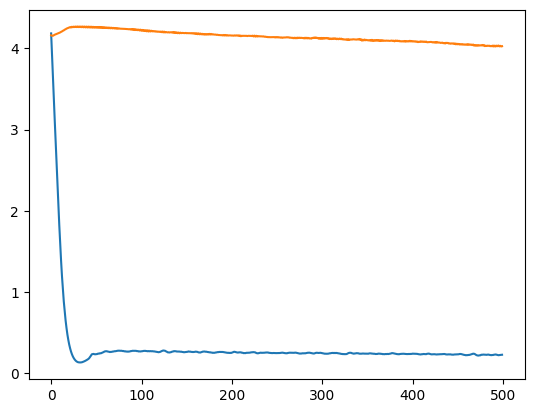

In [8]:
import matplotlib.pyplot as plt

model = SOREG( l=10,lamb1 = 0.001, lamb2 =0.001, learning_rate=0.005, epochs= 500)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_list = torch.tensor(train_loss_list).detach().numpy()
test_loss_list = torch.tensor(test_loss_list).detach().numpy()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')

In [5]:
train_toy = np.array([
    [5, 2, 0, 3, 0, 4, 0, 0],
    [4, 3, 0, 0, 5, 0, 0, 0],
    [4, 0, 2, 0, 0, 0, 2, 4],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [5, 1, 2, 0, 4, 3, 0, 0],
    [4, 3, 0, 2, 4, 0, 3, 5]
], dtype=float)


trust_toy = np.array([
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1.0, 0.8],
            [0.8,0, 0,0,0,0],
            [0.8, 1.0, 0, 0, 0.6, 0],
            [0,0, 0.4, 0, 0, 0.8],
            [0,0,0,0,0,0]])

In [6]:
model = SOREG(train_R = train_toy, test_R = train_toy, learning_rate = 0.001, trust = trust_toy, l=10, epochs = 3000)

model.fit()
print(model.get_complete_matrix())

<ipython-input-3-446d32b864b2>:48: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  predicted_rating = torch.matmul(self.U[:, u].T, self.V) # (l,) (l, n) => (n)


Epoch [0/3000], total_loss: 113.31383514404297, train_mae: 4.407568844881925, test_mae: 4.407568844881925
Epoch [200/3000], total_loss: 29.673797607421875, train_mae: 2.044202457774769, test_mae: 2.044202457774769
Epoch [400/3000], total_loss: 3.458954095840454, train_mae: 0.5771648233587091, test_mae: 0.5771648233587091
Epoch [600/3000], total_loss: 0.4853697419166565, train_mae: 0.1979534842751243, test_mae: 0.1979534842751243
Epoch [800/3000], total_loss: 0.07906012237071991, train_mae: 0.061745508150620895, test_mae: 0.061745508150620895
Epoch [1000/3000], total_loss: 0.026474066078662872, train_mae: 0.00625776160847057, test_mae: 0.00625776160847057
Epoch [1200/3000], total_loss: 0.025673536583781242, train_mae: 0.0013760490850968795, test_mae: 0.0013760490850968795
Epoch [1400/3000], total_loss: 0.02512681484222412, train_mae: 0.0013262358578768644, test_mae: 0.0013262358578768644
Epoch [1600/3000], total_loss: 0.024251624941825867, train_mae: 0.0012960650704123757, test_mae: 0.0